In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
import evaluate
import torch

In [4]:
dataset = load_dataset("mediabiasgroup/BABE")

README.md:   0%|          | 0.00/770 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/712k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3121 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [5]:
# Use only 'text' and 'label' columns
def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length")
# Load tokenizer and model
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
device = torch.device("cuda:0")  # Or "cuda:1" if that's your best GPU
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [7]:
# Preprocess dataset
encoded_dataset = dataset.map(preprocess, batched=True)
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/3121 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [8]:
# Load evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

In [9]:
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }

In [10]:
# Training configuration
training_args = TrainingArguments(
    output_dir="./roberta-babe",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    no_cuda=False,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=10,
)

In [11]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_2076135/1945827288.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
# Train
trainer.train()

/home/himel/miniconda3/envs/graco/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.328400,0.399587,0.833000,0.833197
2,0.300600,0.340090,0.852000,0.852337
3,0.230700,0.393154,0.852000,0.852483


/home/himel/miniconda3/envs/graco/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/himel/miniconda3/envs/graco/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/himel/miniconda3/envs/graco/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=294, training_loss=0.321795669339952, metrics={'train_runtime': 136.959, 'train_samples_per_second': 68.364, 'train_steps_per_second': 2.147, 'total_flos': 2463508811335680.0, 'train_loss': 0.321795669339952, 'epoch': 3.0})

In [13]:
# Save model
trainer.save_model("./roberta-babe")

In [14]:
from transformers import pipeline

bias_detector = pipeline("text-classification", model="./roberta-babe", tokenizer="roberta-base")

Device set to use cuda:0


In [15]:
print(bias_detector("The Earth is a planet."))
print(bias_detector("Immigrants are criminals."))

[{'label': 'LABEL_0', 'score': 0.9305679798126221}]
[{'label': 'LABEL_1', 'score': 0.9843938946723938}]


## Evaluation

In [67]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [68]:
# Load test split from BABE
data = load_dataset("mediabiasgroup/BABE", split="test")

In [22]:
# Print results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.8520
Precision: 0.9237
Recall:    0.8014
F1 Score:  0.8582


In [66]:
# Use a pipeline as a high-level helper
from transformers import pipeline

detect = pipeline("text-classification", model="himel7/bias-detector")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [70]:
# Prepare predictions and ground truth
true_labels = []
pred_labels = []

for example in data:
    text = example["text"]
    true_label = example["label"]
    
    # Run prediction
    prediction = detect(text)[0]
    pred_label = 1 if prediction["label"] == "LABEL_1" else 0

    true_labels.append(true_label)
    pred_labels.append(pred_label)

In [73]:
# Compute metrics
accuracy2 = accuracy_score(true_labels, pred_labels)
precision2, recall2, f1_2, _ = precision_recall_fscore_support(true_labels, pred_labels, average="binary")

In [74]:
# Print results
print(f"Accuracy:  {accuracy2:.4f}")
print(f"Precision: {precision2:.4f}")
print(f"Recall:    {recall2:.4f}")
print(f"F1 Score:  {f1_2:.4f}")

Accuracy:  0.8520
Precision: 0.9237
Recall:    0.8014
F1 Score:  0.8582


In [80]:
piper = pipeline("text-classification", model="mediabiasgroup/da-roberta-babe-ft")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [83]:
r=piper("Trump is a moron.")

In [84]:
r

[{'label': 'LABEL_1', 'score': 0.966972827911377}]

## K-fold Cross Validation on Himel's model

In [1]:
from datasets import load_dataset, concatenate_datasets
from sklearn.model_selection import KFold
from transformers import pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the full BABE dataset (concatenate train and test)
babe_train = load_dataset("mediabiasgroup/BABE", split="train")
babe_test = load_dataset("mediabiasgroup/BABE", split="test")
full_dataset = concatenate_datasets([babe_train, babe_test])

In [3]:
# Convert to list for indexing
examples = full_dataset["text"]
labels = full_dataset["label"]

In [4]:
len(examples)

4121

In [5]:
# Initialize model pipeline (hosted on HF Hub)
bias_detector = pipeline("text-classification", model="himel7/bias-detector", tokenizer="roberta-base")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [6]:
# K-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

all_preds_A = []
all_trues_A = []

fold_scores = []

In [7]:
for fold, (train_index, test_index) in enumerate(kf.split(examples)):
    print(f"\n🔁 Fold {fold+1}/{k}")

    test_texts = [examples[i] for i in test_index]
    true_labels = [labels[i] for i in test_index]

    pred_labels = []
    for text in test_texts:
        result = bias_detector(text, truncation=True)[0]
        pred = 1 if result["label"] == "LABEL_1" else 0
        pred_labels.append(pred)

    # Evaluate
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="binary")

    print(f"Accuracy:  {accuracy:.4f}  |  Precision: {precision:.4f}  |  Recall: {recall:.4f}  |  F1: {f1:.4f}")
    fold_scores.append((accuracy, precision, recall, f1))

    all_preds_A.extend(pred_labels)
    all_trues_A.extend(true_labels)

# Average metrics across folds
avg_metrics = np.mean(fold_scores, axis=0)


🔁 Fold 1/5
Accuracy:  0.9200  |  Precision: 0.9770  |  Recall: 0.8833  |  F1: 0.9278

🔁 Fold 2/5
Accuracy:  0.9066  |  Precision: 0.9456  |  Recall: 0.8811  |  F1: 0.9122

🔁 Fold 3/5
Accuracy:  0.9248  |  Precision: 0.9587  |  Recall: 0.8977  |  F1: 0.9272

🔁 Fold 4/5
Accuracy:  0.9248  |  Precision: 0.9564  |  Recall: 0.9065  |  F1: 0.9308

🔁 Fold 5/5
Accuracy:  0.9248  |  Precision: 0.9697  |  Recall: 0.8946  |  F1: 0.9306


In [9]:
print("\n📊 Average Metrics Across Folds")
print(f"Accuracy:  {avg_metrics[0]:.4f}")
print(f"Precision: {avg_metrics[1]:.4f}")
print(f"Recall:    {avg_metrics[2]:.4f}")
print(f"F1 Score:  {avg_metrics[3]:.4f}")


📊 Average Metrics Across Folds
Accuracy:  0.9202
Precision: 0.9615
Recall:    0.8927
F1 Score:  0.9257


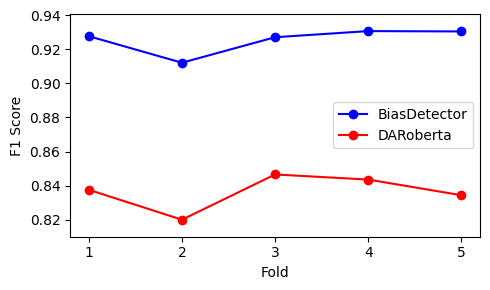

In [67]:
import matplotlib.pyplot as plt

# Replace these with your real F1 scores from the k-fold evaluation
f1_scores = [0.9278, 0.9122, 0.9272, 0.9308, 0.9306]
f1_scores2 = [0.8375, 0.8199, 0.8465, 0.8435, 0.8343]

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o', linestyle='-', color='blue', label='BiasDetector')
plt.plot(range(1, len(f1_scores2) + 1), f1_scores2, marker='o', linestyle='-', color='red', label='DARoberta')
#plt.title('F1 Score per K-Fold')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.xticks(range(1, len(f1_scores) + 1))
plt.ylim(min(f1_scores2) - 0.01, max(f1_scores) + 0.01)
plt.legend()
plt.tight_layout()
plt.show()


In [145]:
import numpy as np

f1_scores = [0.9278, 0.9122, 0.9272, 0.9308, 0.9306]
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores, ddof=1)  # sample standard deviation
se_f1 = std_f1 / np.sqrt(len(f1_scores))

print(f"Mean Macro F1-score: {mean_f1:.4f}")
print(f"Standard Error: {se_f1:.4f}")

Mean Macro F1-score: 0.9257
Standard Error: 0.0035


## K-fold evaluation on Spinde's model:

In [10]:
# Initialize model pipeline (hosted on HF Hub)
bias_detector2 = pipeline("text-classification", model="mediabiasgroup/da-roberta-babe-ft", tokenizer="roberta-base")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [11]:
# K-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

all_preds2 = []
all_trues2 = []

fold_scores2 = []

In [12]:
for fold, (train_index, test_index) in enumerate(kf.split(examples)):
    print(f"\n🔁 Fold {fold+1}/{k}")

    test_texts = [examples[i] for i in test_index]
    true_labels = [labels[i] for i in test_index]

    pred_labels = []
    for text in test_texts:
        result = bias_detector2(text, truncation=True)[0]
        pred = 1 if result["label"] == "LABEL_1" else 0
        pred_labels.append(pred)

    # Evaluate
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="binary")

    print(f"Accuracy:  {accuracy:.4f}  |  Precision: {precision:.4f}  |  Recall: {recall:.4f}  |  F1: {f1:.4f}")
    fold_scores2.append((accuracy, precision, recall, f1))

    all_preds2.extend(pred_labels)
    all_trues2.extend(true_labels)


🔁 Fold 1/5
Accuracy:  0.8339  |  Precision: 0.9725  |  Recall: 0.7354  |  F1: 0.8375

🔁 Fold 2/5
Accuracy:  0.8240  |  Precision: 0.9402  |  Recall: 0.7269  |  F1: 0.8199

🔁 Fold 3/5
Accuracy:  0.8544  |  Precision: 0.9678  |  Recall: 0.7523  |  F1: 0.8465

🔁 Fold 4/5
Accuracy:  0.8447  |  Precision: 0.9637  |  Recall: 0.7500  |  F1: 0.8435

🔁 Fold 5/5
Accuracy:  0.8337  |  Precision: 0.9530  |  Recall: 0.7419  |  F1: 0.8343


In [13]:
# Average metrics across folds
avg_metrics2 = np.mean(fold_scores2, axis=0)

In [14]:
print("\n📊 Average Metrics Across Folds")
print(f"Accuracy:  {avg_metrics2[0]:.4f}")
print(f"Precision: {avg_metrics2[1]:.4f}")
print(f"Recall:    {avg_metrics2[2]:.4f}")
print(f"F1 Score:  {avg_metrics2[3]:.4f}")


📊 Average Metrics Across Folds
Accuracy:  0.8381
Precision: 0.9594
Recall:    0.7413
F1 Score:  0.8364


In [146]:
import numpy as np

f1_scores = [0.8375, 0.8199, 0.8465, 0.8435, 0.8343]
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores, ddof=1)  # sample standard deviation
se_f1 = std_f1 / np.sqrt(len(f1_scores))

print(f"Mean Macro F1-score: {mean_f1:.4f}")
print(f"Standard Error: {se_f1:.4f}")

Mean Macro F1-score: 0.8363
Standard Error: 0.0046


In [30]:
bias_detector3 = pipeline("text-classification", model="mediabiasgroup/da-roberta-pt", tokenizer="roberta-base")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [31]:
all_preds3 = []
all_trues3 = []

fold_scores3 = []

for fold, (train_index, test_index) in enumerate(kf.split(examples)):
    print(f"\n🔁 Fold {fold+1}/{k}")

    test_texts = [examples[i] for i in test_index]
    true_labels = [labels[i] for i in test_index]

    pred_labels = []
    for text in test_texts:
        result = bias_detector3(text, truncation=True)[0]
        pred = 1 if result["label"] == "LABEL_1" else 0
        pred_labels.append(pred)

    # Evaluate
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="binary")

    print(f"Accuracy:  {accuracy:.4f}  |  Precision: {precision:.4f}  |  Recall: {recall:.4f}  |  F1: {f1:.4f}")
    fold_scores3.append((accuracy, precision, recall, f1))

    all_preds3.extend(pred_labels)
    all_trues3.extend(true_labels)

# Average metrics across folds
avg_metrics3 = np.mean(fold_scores3, axis=0)



🔁 Fold 1/5
Accuracy:  0.5818  |  Precision: 0.5818  |  Recall: 1.0000  |  F1: 0.7356

🔁 Fold 2/5
Accuracy:  0.5510  |  Precision: 0.5510  |  Recall: 1.0000  |  F1: 0.7105

🔁 Fold 3/5
Accuracy:  0.5340  |  Precision: 0.5340  |  Recall: 1.0000  |  F1: 0.6962

🔁 Fold 4/5
Accuracy:  0.5583  |  Precision: 0.5583  |  Recall: 1.0000  |  F1: 0.7165

🔁 Fold 5/5
Accuracy:  0.5643  |  Precision: 0.5643  |  Recall: 1.0000  |  F1: 0.7215


In [32]:
print("\n📊 Average Metrics Across Folds")
print(f"Accuracy:  {avg_metrics3[0]:.4f}")
print(f"Precision: {avg_metrics3[1]:.4f}")
print(f"Recall:    {avg_metrics3[2]:.4f}")
print(f"F1 Score:  {avg_metrics3[3]:.4f}")


📊 Average Metrics Across Folds
Accuracy:  0.5579
Precision: 0.5579
Recall:    1.0000
F1 Score:  0.7161


## BIAS Type Classifier- Maximus Powers

In [138]:
bias_type = pipeline("text-classification", model="maximuspowers/bias-type-classifier")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [143]:
r=bias_type("The brave leader saved the country.")

In [144]:
r

[{'label': 'nationality', 'score': 0.9486182928085327}]

### Statistical Significance Testing

In [18]:
from statsmodels.stats.contingency_tables import mcnemar

In [19]:
# Sanity check: all predictions should be on the same test set
assert all_trues_A == all_trues2 or np.array_equal(all_trues_A, all_trues2)

In [20]:
# Construct the contingency table
b = c = 0
for y_true, pred_a, pred_b in zip(all_trues_A, all_preds_A, all_preds2):
    correct_a = pred_a == y_true
    correct_b = pred_b == y_true

    if correct_a and not correct_b:
        b += 1  # A correct, B wrong
    elif not correct_a and correct_b:
        c += 1  # B correct, A wrong

In [21]:
# McNemar contingency table: [[both_correct, A_correct_only], [B_correct_only, both_wrong]]
table = [[0, b], [c, 0]]

In [22]:
# Perform McNemar's test
result = mcnemar(table, exact=False, correction=True)

In [33]:
print("\n📊 McNemar’s Test Results")
print(f"Chi-squared statistic: {result.statistic:.4f}")
print(f"P-value: {result.pvalue:.2e}")


📊 McNemar’s Test Results
Chi-squared statistic: 220.0950
P-value: 8.62e-50


In [24]:
if result.pvalue < 0.05:
    print("✅ Difference is statistically significant (p < 0.05)")
else:
    print("❌ No statistically significant difference (p ≥ 0.05)")

✅ Difference is statistically significant (p < 0.05)


### Full Evaluation Code for Per Fold Statistical Significance Testing

In [34]:
from datasets import load_dataset, concatenate_datasets
from sklearn.model_selection import KFold
from transformers import pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np
from tqdm import tqdm

In [35]:
# Load the full BABE dataset
babe_train = load_dataset("mediabiasgroup/BABE", split="train")
babe_test = load_dataset("mediabiasgroup/BABE", split="test")
full_dataset = concatenate_datasets([babe_train, babe_test])

In [36]:
examples = full_dataset["text"]
labels = full_dataset["label"]

In [38]:
# Initialize both Hugging Face pipelines
model_names = {
    "himel7": "himel7/bias-detector",
    "daroberta": "mediabiasgroup/da-roberta-babe-ft"
}
pipelines = {
    name: pipeline("text-classification", model=model, tokenizer="roberta-base")
    for name, model in model_names.items()
}

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [39]:
# Prepare K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Fold-wise containers
foldwise_preds_model1 = []
foldwise_preds_model2 = []
foldwise_trues = []

In [40]:
# Evaluation loop
for fold, (train_index, test_index) in enumerate(kf.split(examples)):
    print(f"\n🔁 Fold {fold + 1}/{k}")

    test_texts = [examples[i] for i in test_index]
    true_labels = [labels[i] for i in test_index]

    def get_preds(model_pipeline):
        preds = []
        for text in tqdm(test_texts, desc=f"Predicting ({model_pipeline.model.name_or_path})"):
            result = model_pipeline(text, truncation=True)[0]
            pred = 1 if result["label"] == "LABEL_1" else 0
            preds.append(pred)
        return preds

    preds_model1 = get_preds(pipelines["himel7"])
    preds_model2 = get_preds(pipelines["daroberta"])

    foldwise_preds_model1.append(preds_model1)
    foldwise_preds_model2.append(preds_model2)
    foldwise_trues.append(true_labels)


🔁 Fold 1/5


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 825/825 [03:07<00:00,  4.40it/s]



🔁 Fold 2/5


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 824/824 [03:08<00:00,  4.37it/s]



🔁 Fold 3/5


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 824/824 [03:10<00:00,  4.33it/s]



🔁 Fold 4/5


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 824/824 [03:08<00:00,  4.37it/s]



🔁 Fold 5/5


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 824/824 [03:11<00:00,  4.30it/s]


In [41]:
# McNemar's Test function
def run_fold_mcnemar(y_true, preds_a, preds_b):
    b = c = 0
    for yt, a, b_ in zip(y_true, preds_a, preds_b):
        correct_a = a == yt
        correct_b = b_ == yt
        if correct_a and not correct_b:
            b += 1
        elif not correct_a and correct_b:
            c += 1
    table = [[0, b], [c, 0]]
    result = mcnemar(table, exact=False, correction=True)
    return result.statistic, result.pvalue

In [42]:
# Apply McNemar per fold
fold_stats = []
for i in range(len(foldwise_trues)):
    stat, p = run_fold_mcnemar(foldwise_trues[i], foldwise_preds_model1[i], foldwise_preds_model2[i])
    fold_stats.append((stat, p))
    print(f"📊 Fold {i+1}: Chi-squared = {stat:.4f}, p = {p:.4g}")

📊 Fold 1: Chi-squared = 50.5155, p = 1.182e-12
📊 Fold 2: Chi-squared = 40.8091, p = 1.679e-10
📊 Fold 3: Chi-squared = 32.4900, p = 1.198e-08
📊 Fold 4: Chi-squared = 41.4216, p = 1.227e-10
📊 Fold 5: Chi-squared = 51.1776, p = 8.438e-13


In [43]:
# Aggregate stats
mean_stat = np.mean([s for s, _ in fold_stats])
mean_p = np.mean([p for _, p in fold_stats])

In [44]:
print(f"\n📈 Mean Chi-squared: {mean_stat:.4f}")
print(f"📈 Mean p-value: {mean_p:.4g}")


📈 Mean Chi-squared: 43.2827
📈 Mean p-value: 2.455e-09


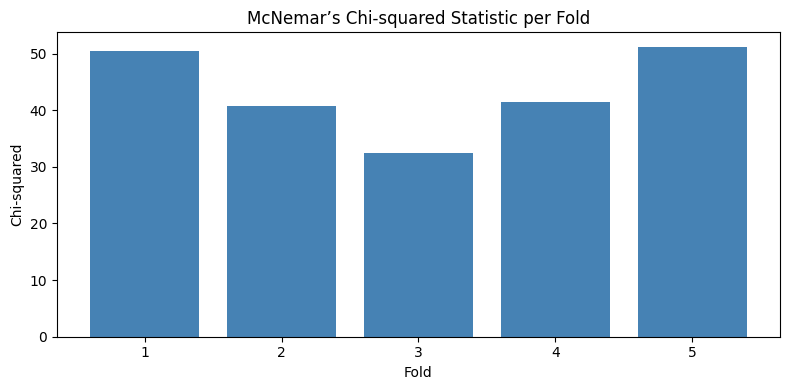

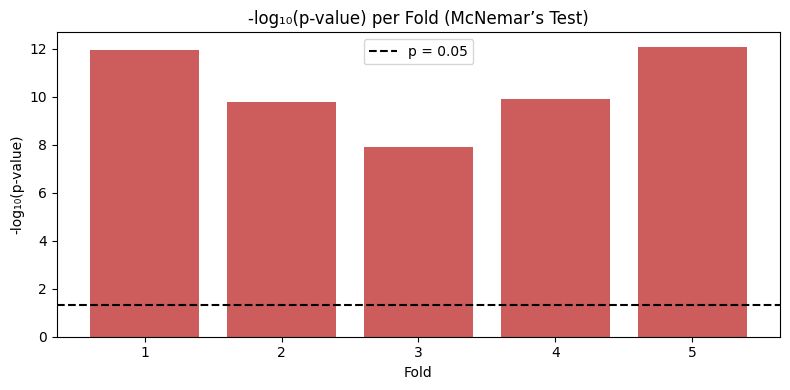

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual values
folds = np.arange(1, 6)
chi_squared = [50.52, 40.81, 32.49, 41.42, 51.18]
p_values = [1.18e-12, 1.68e-10, 1.20e-8, 1.23e-10, 8.44e-13]

# Plot Chi-squared
plt.figure(figsize=(8, 4))
plt.bar(folds, chi_squared, color='steelblue')
plt.title("McNemar’s Chi-squared Statistic per Fold")
plt.xlabel("Fold")
plt.ylabel("Chi-squared")
plt.xticks(folds)
plt.tight_layout()
plt.show()

# Plot -log10(p-value)
plt.figure(figsize=(8, 4))
neg_log_p = -np.log10(p_values)
plt.bar(folds, neg_log_p, color='indianred')
plt.title("-log₁₀(p-value) per Fold (McNemar’s Test)")
plt.xlabel("Fold")
plt.ylabel("-log₁₀(p-value)")
plt.xticks(folds)
plt.axhline(-np.log10(0.05), color='black', linestyle='--', label='p = 0.05')
plt.legend()
plt.tight_layout()
plt.show()


### 5x2 cv test

In [47]:
# Load both model pipelines
model_a = pipeline("text-classification", model="himel7/bias-detector", tokenizer="roberta-base")
model_b = pipeline("text-classification", model="mediabiasgroup/da-roberta-babe-ft", tokenizer="roberta-base")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [62]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score
# 5x2 CV split
cv = ShuffleSplit(n_splits=5, test_size=0.5, random_state=42)
score_diffs = []

In [48]:
def predict(model_pipeline, texts):
    preds = []
    for text in tqdm(texts, desc=f"Predicting ({model_pipeline.model.name_or_path})"):
        result = model_pipeline(text, truncation=True)[0]
        pred = 1 if result["label"] == "LABEL_1" else 0
        preds.append(pred)
    return np.array(preds)

In [64]:
examples_arr = np.array(full_dataset["text"])
labels_arr = np.array(full_dataset["label"])

In [59]:
# Run 5 splits of 2-fold CV
for i, (train_idx, test_idx) in enumerate(cv.split(examples_arr)):
    print(f"\n🔁 5x2 Split {i+1}")
    
    test_texts = examples_arr[test_idx]
    true_labels = labels_arr[test_idx]

    # Predict and evaluate
    preds_a = predict(model_a, test_texts)
    preds_b = predict(model_b, test_texts)

    acc_a = accuracy_score(true_labels, preds_a)
    acc_b = accuracy_score(true_labels, preds_b)

    f1_a = f1_score(true_labels, preds_a)
    f1_b = f1_score(true_labels, preds_b)
    
    diff = acc_a - acc_b
    score_diffs.append(diff)
    
    print(f"Accuracy A: {acc_a:.4f}, Accuracy B: {acc_b:.4f}, Difference: {diff:.4f}")



🔁 5x2 Split 1


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 2061/2061 [07:50<00:00,  4.38it/s]


Accuracy A: 0.9161, Accuracy B: 0.8331, Difference: 0.0830

🔁 5x2 Split 2


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 2061/2061 [07:56<00:00,  4.33it/s]


Accuracy A: 0.9248, Accuracy B: 0.8375, Difference: 0.0873

🔁 5x2 Split 3


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 2061/2061 [07:54<00:00,  4.35it/s]


Accuracy A: 0.9141, Accuracy B: 0.8360, Difference: 0.0781

🔁 5x2 Split 4


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 2061/2061 [07:51<00:00,  4.37it/s]


Accuracy A: 0.9253, Accuracy B: 0.8535, Difference: 0.0718

🔁 5x2 Split 5


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 2061/2061 [07:40<00:00,  4.47it/s]

Accuracy A: 0.9195, Accuracy B: 0.8428, Difference: 0.0767


In [60]:
from scipy import stats
# Perform paired t-test
t_stat, p_value = stats.ttest_rel(score_diffs, [0]*len(score_diffs))

In [61]:
# Report results
print("\n📊 5×2 CV Paired t-test Results")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4g}")
if p_value < 0.05:
    print("✅ Statistically significant difference (p < 0.05)")
else:
    print("❌ No statistically significant difference (p ≥ 0.05)")


📊 5×2 CV Paired t-test Results
T-statistic: 29.7405
P-value: 7.612e-06
✅ Statistically significant difference (p < 0.05)


In [65]:
# Run evaluation on F1 score
for i, (train_idx, test_idx) in enumerate(cv.split(examples_arr)):
    print(f"\n🔁 5x2 Split {i+1}")
    
    test_texts = examples_arr[test_idx]
    true_labels = labels_arr[test_idx]

    preds_a = predict(model_a, test_texts)
    preds_b = predict(model_b, test_texts)

    f1_a = f1_score(true_labels, preds_a)
    f1_b = f1_score(true_labels, preds_b)
    diff = f1_a - f1_b
    score_diffs.append(diff)

    print(f"F1-score A: {f1_a:.4f}, F1-score B: {f1_b:.4f}, Difference: {diff:.4f}")



🔁 5x2 Split 1


Predicting (himel7/bias-detector):   0%|          | 0/2061 [00:00<?, ?it/s]

Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 2061/2061 [07:46<00:00,  4.42it/s]


F1-score A: 0.9219, F1-score B: 0.8310, Difference: 0.0909

🔁 5x2 Split 2


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 2061/2061 [07:58<00:00,  4.31it/s]


F1-score A: 0.9300, F1-score B: 0.8349, Difference: 0.0951

🔁 5x2 Split 3


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 2061/2061 [07:44<00:00,  4.44it/s]


F1-score A: 0.9198, F1-score B: 0.8351, Difference: 0.0847

🔁 5x2 Split 4


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 2061/2061 [07:45<00:00,  4.43it/s]


F1-score A: 0.9299, F1-score B: 0.8517, Difference: 0.0783

🔁 5x2 Split 5


Predicting (mediabiasgroup/da-roberta-babe-ft): 100%|██████████| 2061/2061 [07:52<00:00,  4.36it/s]

F1-score A: 0.9248, F1-score B: 0.8404, Difference: 0.0844


In [66]:
# Perform paired t-test
t_stat, p_value = stats.ttest_rel(score_diffs, [0]*len(score_diffs))

# Report results
print("\n📊 5×2 CV Paired t-test (F1-score) Results")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4g}")
if p_value < 0.05:
    print("✅ Statistically significant difference (p < 0.05)")
else:
    print("❌ No statistically significant difference (p ≥ 0.05)")


📊 5×2 CV Paired t-test (F1-score) Results
T-statistic: 29.8111
P-value: 7.54e-06
✅ Statistically significant difference (p < 0.05)


## Visualisations for Interpretability

In [68]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "himel7/bias-detector"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [133]:
text = "The brave leader saved the country."
inputs = tokenizer(text, return_tensors="pt", truncation=True)

with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  # list of layers, each of shape (batch, heads, tokens, tokens)

In [134]:
# Example: average attention from [CLS] token to others in the last layer
last_layer = attentions[-1][0]  # shape: (heads, tokens, tokens)
cls_attn = last_layer[:, 0, :]  # attention from CLS to each token
avg_cls_attn = cls_attn.mean(dim=0).numpy()  # mean over heads

/var/folders/4j/lfyylb311zz43rwm57kmmfpw0000gn/T/ipykernel_66696/1183684801.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


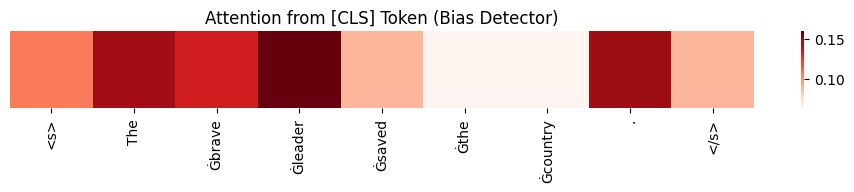

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
plt.figure(figsize=(12, 1))
sns.heatmap([avg_cls_attn], xticklabels=tokens, cmap="Reds", cbar=True, annot=False)
plt.title("Attention from [CLS] Token (Bias Detector)")
plt.xticks(rotation=90)
plt.yticks([])
plt.tight_layout()
plt.show()

In [116]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name2 = "mediabiasgroup/da-roberta-babe-ft"
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)
model2 = AutoModelForSequenceClassification.from_pretrained(model_name2, output_attentions=True)
model2.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

/var/folders/4j/lfyylb311zz43rwm57kmmfpw0000gn/T/ipykernel_66696/2134812870.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


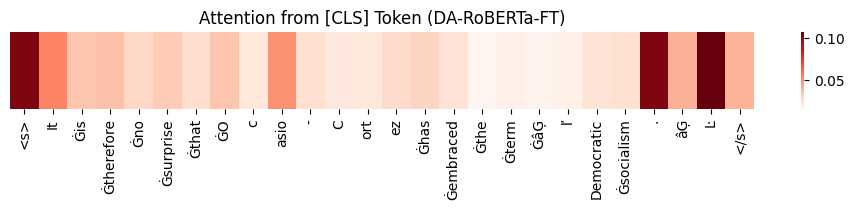

In [128]:
#text = "The success of the Trump administration’s Operation Warp Speed stands as one of the greatest achievements of the Trump presidency, or any presidency."
text = "It is therefore no surprise that Ocasio-Cortez has embraced the term “Democratic socialism.”"
inputs = tokenizer2(text, return_tensors="pt", truncation=True)

with torch.no_grad():
    outputs = model2(**inputs)
    attentions = outputs.attentions  # list of layers, each of shape (batch, heads, tokens, tokens)

# Example: average attention from [CLS] token to others in the last layer
last_layer = attentions[-1][0]  # shape: (heads, tokens, tokens)
cls_attn = last_layer[:, 0, :]  # attention from CLS to each token
avg_cls_attn = cls_attn.mean(dim=0).numpy()  # mean over heads

import matplotlib.pyplot as plt
import seaborn as sns

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
plt.figure(figsize=(12, 1))
sns.heatmap([avg_cls_attn], xticklabels=tokens, cmap="Reds", cbar=True, annot=False)
plt.title("Attention from [CLS] Token (DA-RoBERTa-FT)")
plt.xticks(rotation=90)
plt.yticks([])
plt.tight_layout()
plt.show()

In [131]:
r=bias_detector2("The brave leader saved the country.")

In [132]:
r

[{'label': 'LABEL_0', 'score': 0.7416158318519592}]

In [102]:
false_negatives = []
false_positives = []

for text, true_label in zip(examples, labels):
    pred = bias_detector2(text, truncation=True)[0]
    pred_label = 1 if pred["label"] == "LABEL_1" else 0

    if true_label == 1 and pred_label == 0:
        false_negatives.append((text, pred["score"]))  # missed bias
    elif true_label == 0 and pred_label == 1:
        false_positives.append((text, pred["score"]))  # false bias detection


In [103]:
print("🔴 False Negatives (Missed Biased Sentences):")
for text, score in false_negatives[:5]:
    print(f"[Score: {score:.2f}] {text}\n")

print("\n🟡 False Positives (Neutral labeled Biased):")
for text, score in false_positives[:5]:
    print(f"[Score: {score:.2f}] {text}\n")


🔴 False Negatives (Missed Biased Sentences):
[Score: 0.92] The success of the Trump administration’s Operation Warp Speed stands as one of the greatest achievements of the Trump presidency, or any presidency.

[Score: 0.83] China’s Communist party government demonstrated its sensitivity about Covid’s origin, with state-run media outlet the Global Times issuing a warning to Elon Musk not to risk his relationship with China, after he sent tweets discussing the Department of Energy report on the lab leak theory.

[Score: 0.63] As Congress begins debating the Equality Act, the Heritage Foundation warns that if the bill becomes law it will prove the death knell for women’s sports.

[Score: 0.96] Several medical and advocacy groups have insisted abortion services should be considered as essential health care during the Chinese coronavirus pandemic and not subject to delays or a reduction of availability that will affect other health services.

[Score: 0.87] First Joe Biden said he still supp

In [96]:
# Find first example where DA-RoBERTa fails on a biased sentence
for text, label in zip(examples, labels):
    if label == 1:
        prediction = bias_detector2(text, truncation=True)[0]
        if prediction["label"] == "LABEL_0":
            print("🔍 Found a failure case:")
            print(f"Text: {text}")
            print(f"True Label: Biased (1)")
            print(f"DA-RoBERTa Prediction: {prediction}")
            break

🔍 Found a failure case:
Text: The success of the Trump administration’s Operation Warp Speed stands as one of the greatest achievements of the Trump presidency, or any presidency.
True Label: Biased (1)
DA-RoBERTa Prediction: {'label': 'LABEL_0', 'score': 0.9221115112304688}


In [136]:
r=bias_detector("The leader saved the country.")

In [137]:
r

[{'label': 'LABEL_0', 'score': 0.9107587337493896}]